# Mask detection with TensorFlow

This notebook contains a simple implementation of a Deep Learning model for **real time object detection**. In this particular case, the object to be detected is a **mask**.

The model presented in this repository has been totally implemented using open source tools (i.e., Python 3 and TensorFlow 2), and is designed to be run on an a system with a NVIDIA graphics card with CUDA architectures (so we can take advantage of *tensorflow-gpu* to speed up the training).

I got idea to design this model after watching one of the YouTube videos by [Nicholas Renotte](https://www.youtube.com/watch?v=yqkISICHH-U). Some of the steps followed in this project, resemble what he has done for other use cases (e.g., sign object detection). I also used an amazing graphical image annotation package, *LabelImg*, developed by [Tzuta Lin](https://github.com/tzutalin/labelImg).


## Imports

In [1]:
# General imports
import numpy as np ; np.random.seed(1) # for reproducibility
import pandas as pd
import cv2 
import uuid
import os
import time
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import requests
import tarfile
import json
import time
from google.protobuf import text_format

# TensorFlow
import tensorflow as tf
from tensorflow import keras

### TensorFlow information

In [2]:
# Indicate the version of Tensorflow and whether it uses the CPU or the GPU
print("TensorFlow version:", tf.__version__)

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("The GPU will be used for calculations.")
    
else:
    print("The CPU will be used for calculations.")

TensorFlow version: 2.4.1
The GPU will be used for calculations.


## Functions

In [3]:
def countdown(number):
    
    """
    Print countdown.
    
    Parameters:
    number (int): Number used for the countdown in seconds.
    """
    
    for i in range(number,0,-1):
        print('{}...'.format(i))
        time.sleep(1)

In [4]:
def take_pictures(list_classes, number_pictures, path_data_raw, number, device):
    
    """
    Take pictures from the webcam every X seconds and save the data locally.
    
    Parameters:
    list_classes (list): List of possible classes to be pictured.
    number_pictures (int): Number specifing the number of pictures per class to be taken.
    path_data_raw (Path): Path to the folder where the images must be saved.
    number (int): Number used for the countdown in seconds.
    device (string): Either the 'built-in' camera, or the 'external' one (useful for laptops).
    """
    
    # Define time before start
    start_gap = 5

    # Print info 
    print('\nWe will take pictures for {} classes: {}'.format(len(list_classes), list_classes))
    print('Will start in about {} seconds...'.format(start_gap))
    time.sleep(start_gap)
    
    # Iterate over each class
    for label in list_classes:
        
        # Print info
        print("\n - Let's take {} pictures for {}: \n".format(number_pictures, label))
        time.sleep(number)
        
        # Select camera
        if device == 'built-in':
            camera = cv2.VideoCapture(0)
        elif device == 'external':
            camera = cv2.VideoCapture(1)
        
        # Take the number of pictures specified
        for pic in range(1, number_pictures + 1):
            
            # Print countdown until picture
            countdown(number)
            
            # Take picture
            print('Photo {}! ({}) \n'.format(pic, label))
            _, image = camera.read()
            
            # Save image
            img_path = os.path.join(path_data_raw, label, '{}_{}.jpg'.format(label, pic))
            print(img_path)
            cv2.imwrite(img_path, image)
        
        # Wait before next class
        time.sleep(3)
    
    # Close camera
    camera.release()
    del(camera)
    cv2.destroyAllWindows()

In [5]:
def restart_directory(path):
    
    """
    Restart a directory:
        If it already exists, remove it and creates a new one.
        If it doesn't exist yet, create it.
    
    Parameters:
    path_data_raw (Path): Path to the folder to be restarted.
    """

    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.mkdir(path)

## Set up directories

In [6]:
# Set data paths
PATH_DATA = Path('data')
PATH_RAW_DATA = Path(os.path.join(PATH_DATA, 'raw'))
PATH_PROCESSED_DATA = Path(os.path.join(PATH_DATA, 'processed'))
PATH_RECORDS_DATA = Path(os.path.join(PATH_DATA, 'records'))

# Set model paths
PATH_PRE_TRAINED = Path('pre_trained_model')
PATH_MODEL = Path('model')

# Set secondary sub-folders
PATH_MASK = Path(os.path.join(PATH_RAW_DATA, 'Mask')) 
PATH_NO_MASK = Path(os.path.join(PATH_RAW_DATA, 'No-mask'))
TRAIN_DATA = Path(os.path.join(PATH_PROCESSED_DATA, 'train')) 
TEST_DATA = Path(os.path.join(PATH_PROCESSED_DATA, 'test'))
PATH_IMAGES = Path('img')

# Set path to Tensorflow folders
PATH_TENSORFLOW = Path('Tensorflow')
PATH_TENSORFLOW_RESEARCH = Path(os.path.join(PATH_TENSORFLOW, 'models', 'research'))
PATH_OBJECT_DETECTION = Path(os.path.join(PATH_TENSORFLOW_RESEARCH, 'object_detection'))
PATH_ANNOTATIONS = Path('annotations')

## Notebook options

In [7]:
# Specify if you want to retrain the model (around 5 hours in a GTX GPU)
retrain_model = False

# Specify if you want to refresh pictures
refresh_pictures = False

In [8]:
if retrain_model or refresh_pictures:
    
    # Restart main folders
    restart_directory(PATH_PROCESSED_DATA) 
    restart_directory(PATH_RECORDS_DATA)
    restart_directory(PATH_PRE_TRAINED)
    restart_directory(PATH_ANNOTATIONS)
    restart_directory(TRAIN_DATA) 
    restart_directory(TEST_DATA)

## Import data

In this section, we will generate the training, validation and test sets, which will be composed of actual images taken by ourselves.

In [9]:
# Define classes
classes = ['Mask', 'No-mask']

In [10]:
if refresh_pictures:
    
    # Remove previous stored pictures
    restart_directory(PATH_MASK) 
    restart_directory(PATH_NO_MASK)
    
    # Take X pictures for each class every Y seconds and save them locally
    take_pictures(classes, 20, PATH_RAW_DATA, 2, 'external') # I use an external webcam

## Describe data

In [11]:
# Describe data size
for label in classes:
    
    # Get list of files in folder
    list_files = os.listdir(os.path.join(PATH_DATA, 'raw', label))

    # Avoid non-relevant elements in folders
    list_files = [pic for pic in list_files if pic.endswith('.jpg')]
    
    # Print number of pictures per folder
    num_files = len(list_files)
    print('Total {} images: {}'.format(label, num_files))

Total Mask images: 20
Total No-mask images: 20


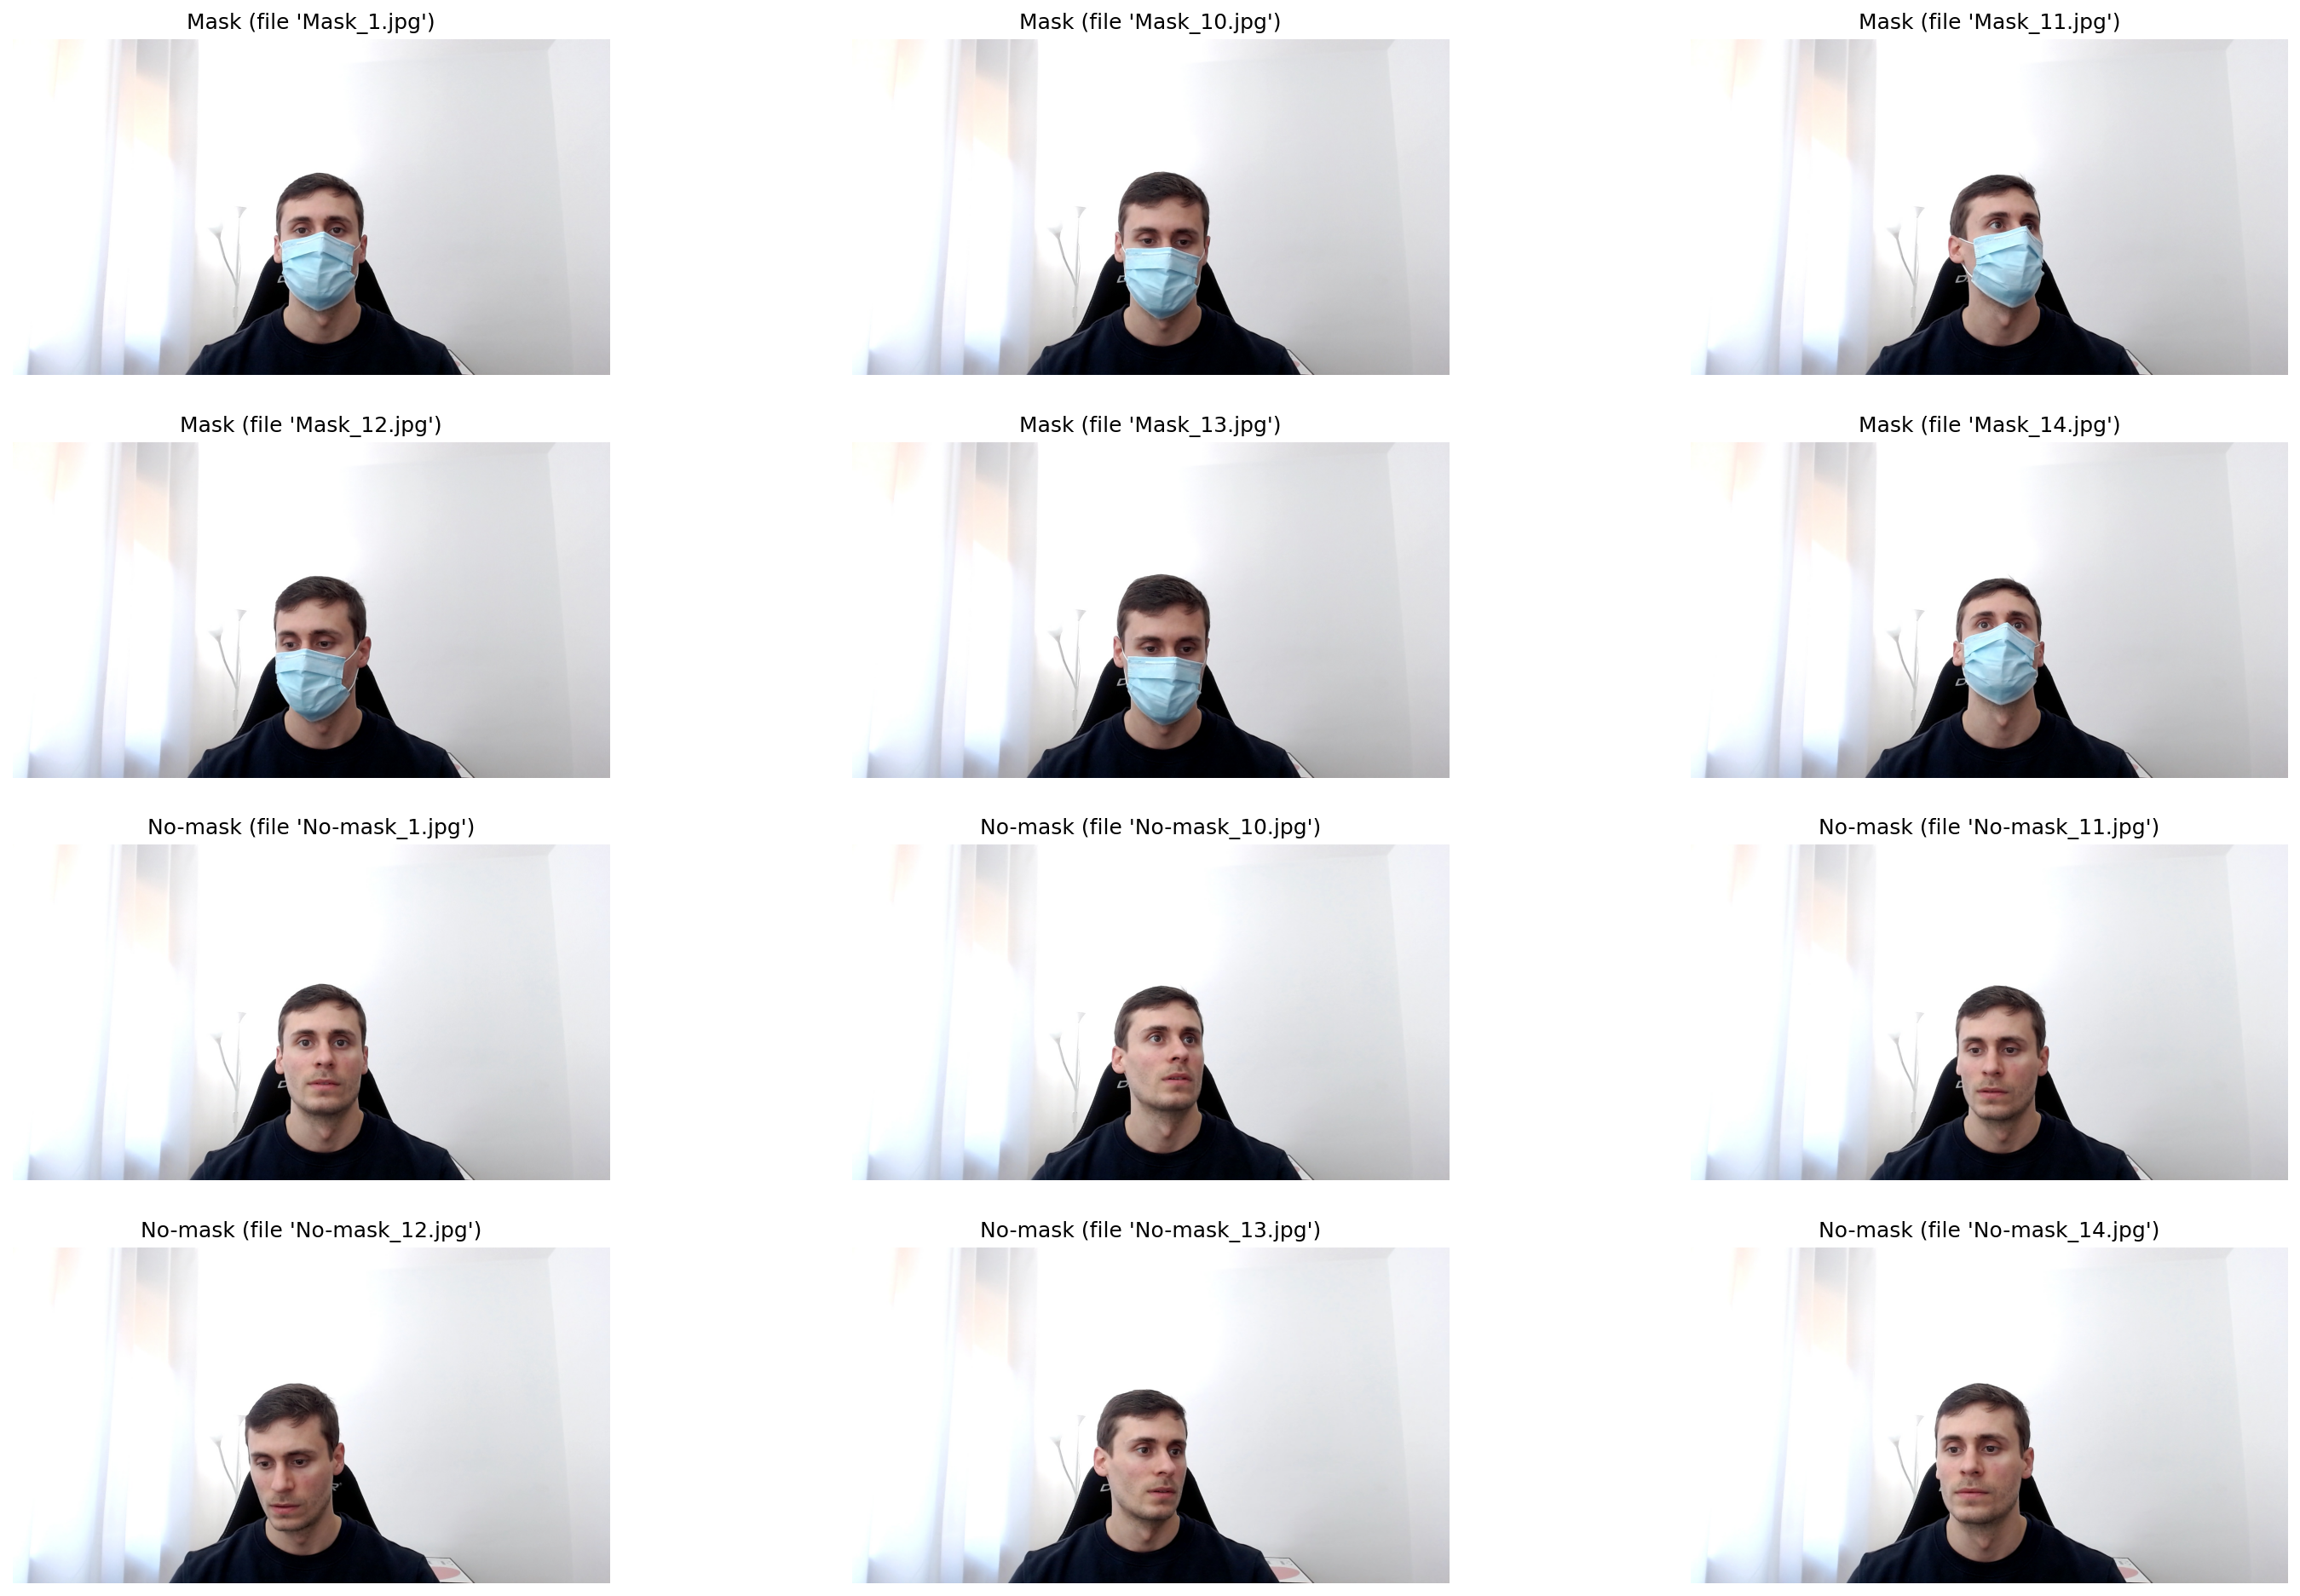

In [12]:
# Increase plot ressolution
plt.rcParams['figure.dpi']= 150

# Number of pictures in the grid
nrows = 4
ncols = 3

# Set up matplotlib fig
longitude_image = 8 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image / 2)

# List all files per folder
mask_files = os.listdir(PATH_MASK)
no_mask_files = os.listdir(PATH_NO_MASK)

# Remove non-relevant elements in folders
mask_files = [pic for pic in mask_files if pic.endswith('.jpg')]
no_mask_files = [pic for pic in no_mask_files if pic.endswith('.jpg')]

# Get paths to each file
list_mask_pix = [os.path.join(PATH_MASK, fname) for fname in mask_files]
list_no_mask_pix = [os.path.join(PATH_NO_MASK, fname) for fname in no_mask_files]

# Get each image
for i, img_path in enumerate(list_mask_pix[:(ncols*2)] + list_no_mask_pix[:(ncols*2)]):
    
    # Windows format
    if '\\' in img_path: 
        folder_name = img_path.split('\\')[2]
        picture_name = img_path.split('\\')[3]
    
    # Unix format
    else:
        folder_name = img_path.split('/')[2]
        picture_name = img_path.split('/')[3]
        
    # Final plot set up
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title("{} (file '{}')".format(folder_name.capitalize(), picture_name))

# Save image
plt.savefig(os.path.join(PATH_IMAGES, 'images.png'), dpi=150)

## Label pictures

At this point, we have to label the images. For that purpose, let's use **[LabelImg](https://github.com/tzutalin/labelImg)**, a graphical image annotation tool. 

### Clone LabelImg repo

In [13]:
# Clone labelImg repository
if not os.path.exists('labelImg'):
    !git clone https://github.com/tzutalin/labelImg

### Label images

To set up the labelling tool, you must have *make* installed already in your system. If that's not the case:

- Follow these [instructions](https://stackoverflow.com/questions/32127524/how-to-install-and-use-make-in-windows) for Windows.
- Or these [instructions](https://formulae.brew.sh/formula/make) for macOS.

In [14]:
if refresh_pictures: 
    
    # Set up labelling tool
    !cd labelImg && make qt5py3
    
    # Label images
    !cd labelImg && python labelImg.py

![](img/screenshot_labelling.gif)

## Create train and test set

In [15]:
if retrain_model or refresh_pictures:

    # Make a copy of the pictures files
    list_mask_pix_jpg = list_mask_pix
    list_no_mask_pix_jpg = list_no_mask_pix
    
    # Get list of .jpg as well as .xml (i.e., boundary boxes)
    list_mask_pix_xml = [pic.replace('.jpg', '.xml') for pic in list_mask_pix_jpg]
    list_no_mask_pix_xml = [pic.replace('.jpg', '.xml') for pic in list_no_mask_pix_jpg]

    # Sort list
    list_mask_files = sorted(list_mask_pix_jpg + list_mask_pix_xml)
    list_no_mask_files = sorted(list_no_mask_pix_jpg + list_no_mask_pix_xml)
    
    # Use 20% of the instances as test set
    split = round(len(list_mask_files)*0.8)

    # Get training set
    train_mask = list_mask_files[:split]
    train_no_mask = list_no_mask_files[:split]

    # Get test set
    test_mask = list_mask_files[split:]
    test_no_mask = list_no_mask_files[split:]
    
    # Copy pictures to train/test folders
    for pic in train_mask + train_no_mask:
        shutil.copy2(pic, TRAIN_DATA)
    for pic in test_mask + test_no_mask:
        shutil.copy2(pic, TEST_DATA)

## Create label map

*TensorFlow* requires a label map to transform each label into an integer. 

In [16]:
if retrain_model or refresh_pictures:

    # Create label dictionary
    labels = [
        {'name':'Mask', 'id':1}, 
        {'name':'No-mask', 'id':2}
    ]

    # Save as a new file
    with open(os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt'), 'w') as f:
        for label in labels:
            f.write('item { \n')
            f.write('\tname:\'{}\'\n'.format(label['name']))
            f.write('\tid:{}\n'.format(label['id']))
            f.write('}\n')

## Install Object Detection API from TensorFlow 

The instructions to install the **Object Detection API** have been obtained from this [link](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/index.html).

In [17]:
# Clone TensorFlow models repository
if not os.path.exists(os.path.join(PATH_TENSORFLOW, 'models')):
    restart_directory(PATH_TENSORFLOW) 
    !cd ./Tensorflow && git clone https://github.com/tensorflow/models.git 

### Protobuf installation

Follow these [instructions](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#protobuf-installation-compilation) to install *Protobufs* for the Tensorflow Object Detection API.

### Compile Protobuf

In [18]:
# Compile protos
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=.

### Install COCO API 

In [19]:
# Clone COCO API repository
if not os.path.exists(os.path.join(PATH_TENSORFLOW, 'cocoapi')):
    restart_directory(os.path.join(PATH_TENSORFLOW, 'cocoapi'))
    !cd Tensorflow && pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

### Install the Object Detection API

In [20]:
# Copy setup script
shutil.copy2(os.path.join(PATH_OBJECT_DETECTION, 'packages', 'tf2', 'setup.py'), PATH_TENSORFLOW_RESEARCH);

In [21]:
# Install object_detection API 
# !cd Tensorflow/models/research && python -m pip install .

In [22]:
# Test that the Object Detection API is correctly installed (it takes around 2-3 minutes)
# !cd Tensorflow/models/research && python object_detection/builders/model_builder_tf2_test.py

## Generate TF records

Tensorflow needs the bounding box locations for every image in a specific format (i.e., as a *.TFRecord*).

In [23]:
if retrain_model or refresh_pictures:
    
    # Download converter
    if not os.path.exists('generate_tf_record.py'):
        url = 'https://tensorflow-object-detection-api-tutorial.readthedocs.io/'
        endpoint = 'en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py'
        response = requests.get(url + endpoint, stream=True)
        if response.status_code == 200:
            with open('generate_tfrecord.py', 'wb') as f:
                f.write(response.raw.read())
    
    # Create train records
    !python generate_tfrecord.py -x data/processed/train -l annotations/label_map.pbtxt -o data/records/train.record

    # Create test records
    !python generate_tfrecord.py -x data/processed/test -l annotations/label_map.pbtxt -o data/records/test.record

## Transfer learning 

### Download pre-trained models

Download the desired pre-trained model from the *TensorFlow* [repository](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). For this specific project, we will use the **MobileNet**.

In [27]:
# Select pre-trained model
model_name = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_path = model_name + '.tar.gz'

In [28]:
if retrain_model or refresh_pictures:

    # Download pre-trained model
    if not os.path.exists(os.path.join(PATH_PRE_TRAINED, model_name)):
        response = requests.get(model_url + model_path, stream=True)
        if response.status_code == 200:
            with open(model_path, 'wb') as f:
                f.write(response.raw.read())

        # Decompress file
        tar = tarfile.open(model_path)
        tar.extractall()
        tar.close()

        # Remove compressed file
        os.remove(model_path)

        # Move folder
        shutil.move(model_name, PATH_PRE_TRAINED);

### Configure training

In [29]:
# Import packages
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2

In [30]:
# Set config path
PATH_CONFIG = os.path.join(PATH_PRE_TRAINED, model_name, 'pipeline.config')
PATH_CONFIG_MOD = os.path.join(PATH_MODEL, 'pipeline.config')

In [31]:
if retrain_model or refresh_pictures:
    
    # Restart directory
    restart_directory(PATH_MODEL)
    
    # Define hyper-parameters
    batch_size = 16 # Higher values require more memory, and vice-versa
    steps = 2500
    
    # Get config file
    config = pipeline_pb2.TrainEvalPipelineConfig()
    with tf.io.gfile.GFile(PATH_CONFIG, "r") as f:
        config_old = f.read()
        text_format.Merge(config_old, config)

    # Prepare a modified version of it
    config_new = open(PATH_CONFIG_MOD, "wt")

    # Update values
    config.model.ssd.num_classes = len(classes)
    config.train_config.batch_size = batch_size
    config.train_config.fine_tune_checkpoint = os.path.join(PATH_PRE_TRAINED, model_name, 'checkpoint', 'ckpt-0')
    config.train_config.fine_tune_checkpoint_type = 'detection'
    config.train_config.num_steps = steps
    config.train_config.use_bfloat16 = False
    config.train_input_reader.label_map_path = os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt')
    config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(PATH_RECORDS_DATA,'train.record')]
    config.eval_input_reader[0].label_map_path = os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt')
    config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(PATH_RECORDS_DATA,'test.record')]

    # Save new file
    config_new = text_format.MessageToString(config)
    with tf.io.gfile.GFile(PATH_CONFIG_MOD, "wb") as f:
        f.write(config_new)

## Train model

In [32]:
# Copy executable script to run the model
if not os.path.exists('model_main_tf2.py'):
    shutil.copy2(os.path.join(PATH_OBJECT_DETECTION, 'model_main_tf2.py'), '.');

In [33]:
if retrain_model or refresh_pictures:
    
    # Train model
    !python model_main_tf2.py --model_dir=model/ --pipeline_config_path=model/pipeline.config 

## Evaluate model

Open a new ***Terminal*** (if you are on macOS or Linux) or a new ***CMD*** (if you are on Windows), and run the following command on this current folder:

```
conda activate object_detection
python model_main_tf2.py --model_dir=model/ --pipeline_config_path=model/pipeline.config --checkpoint_dir=model/
```

## Evaluate and monitor training with TensorBoard

If you want to visualise the performance of the model, open a new ***Terminal*** (if you are on macOS or Linux) or a new ***CMD*** (if you are on Windows), and run the following command on this current folder:

```
conda activate object_detection
tensorboard --logdir=model
```

Then, to **open *TensorBoard***, just listen to port 6006: http://localhost:6006/.

This is an example of the information that you should be able to see:

![](img/tensorboard.png)

## Review test images

In [34]:
# Import modules
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [35]:
# Get maximum checkpoint
dir_check = os.listdir(os.path.join('model'))
checkpoints = [file.split('.')[0] for file in dir_check if 'ckpt-' in file]
max_ckpt = str(max([int(s) for s in str(checkpoints) if s.isdigit()]))

# Print maximum chackpoint
print('The maximum checkpoint present in the folder is {}'.format(max_ckpt))

The maximum checkpoint present in the folder is 2


In [36]:
# Load pipeline configuration
configs = config_util.get_configs_from_pipeline_file('model/pipeline.config')
model_config = configs['model']

# Build detection model and restore checkpoint
detection_model = model_builder.build(model_config=model_config, is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

# Select highest 'ckpt' (i.e., latest checkpoint)
ckpt.restore(os.path.join('model', 'ckpt-' + max_ckpt)).expect_partial() 

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [37]:
# Load labels
category_index = label_map_util.create_category_index_from_labelmap(
    os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt'), use_display_name=True
)

In [38]:
def predict_and_plot(img_path):
    img = cv2.imread(img_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=2,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    return plt

### Train set

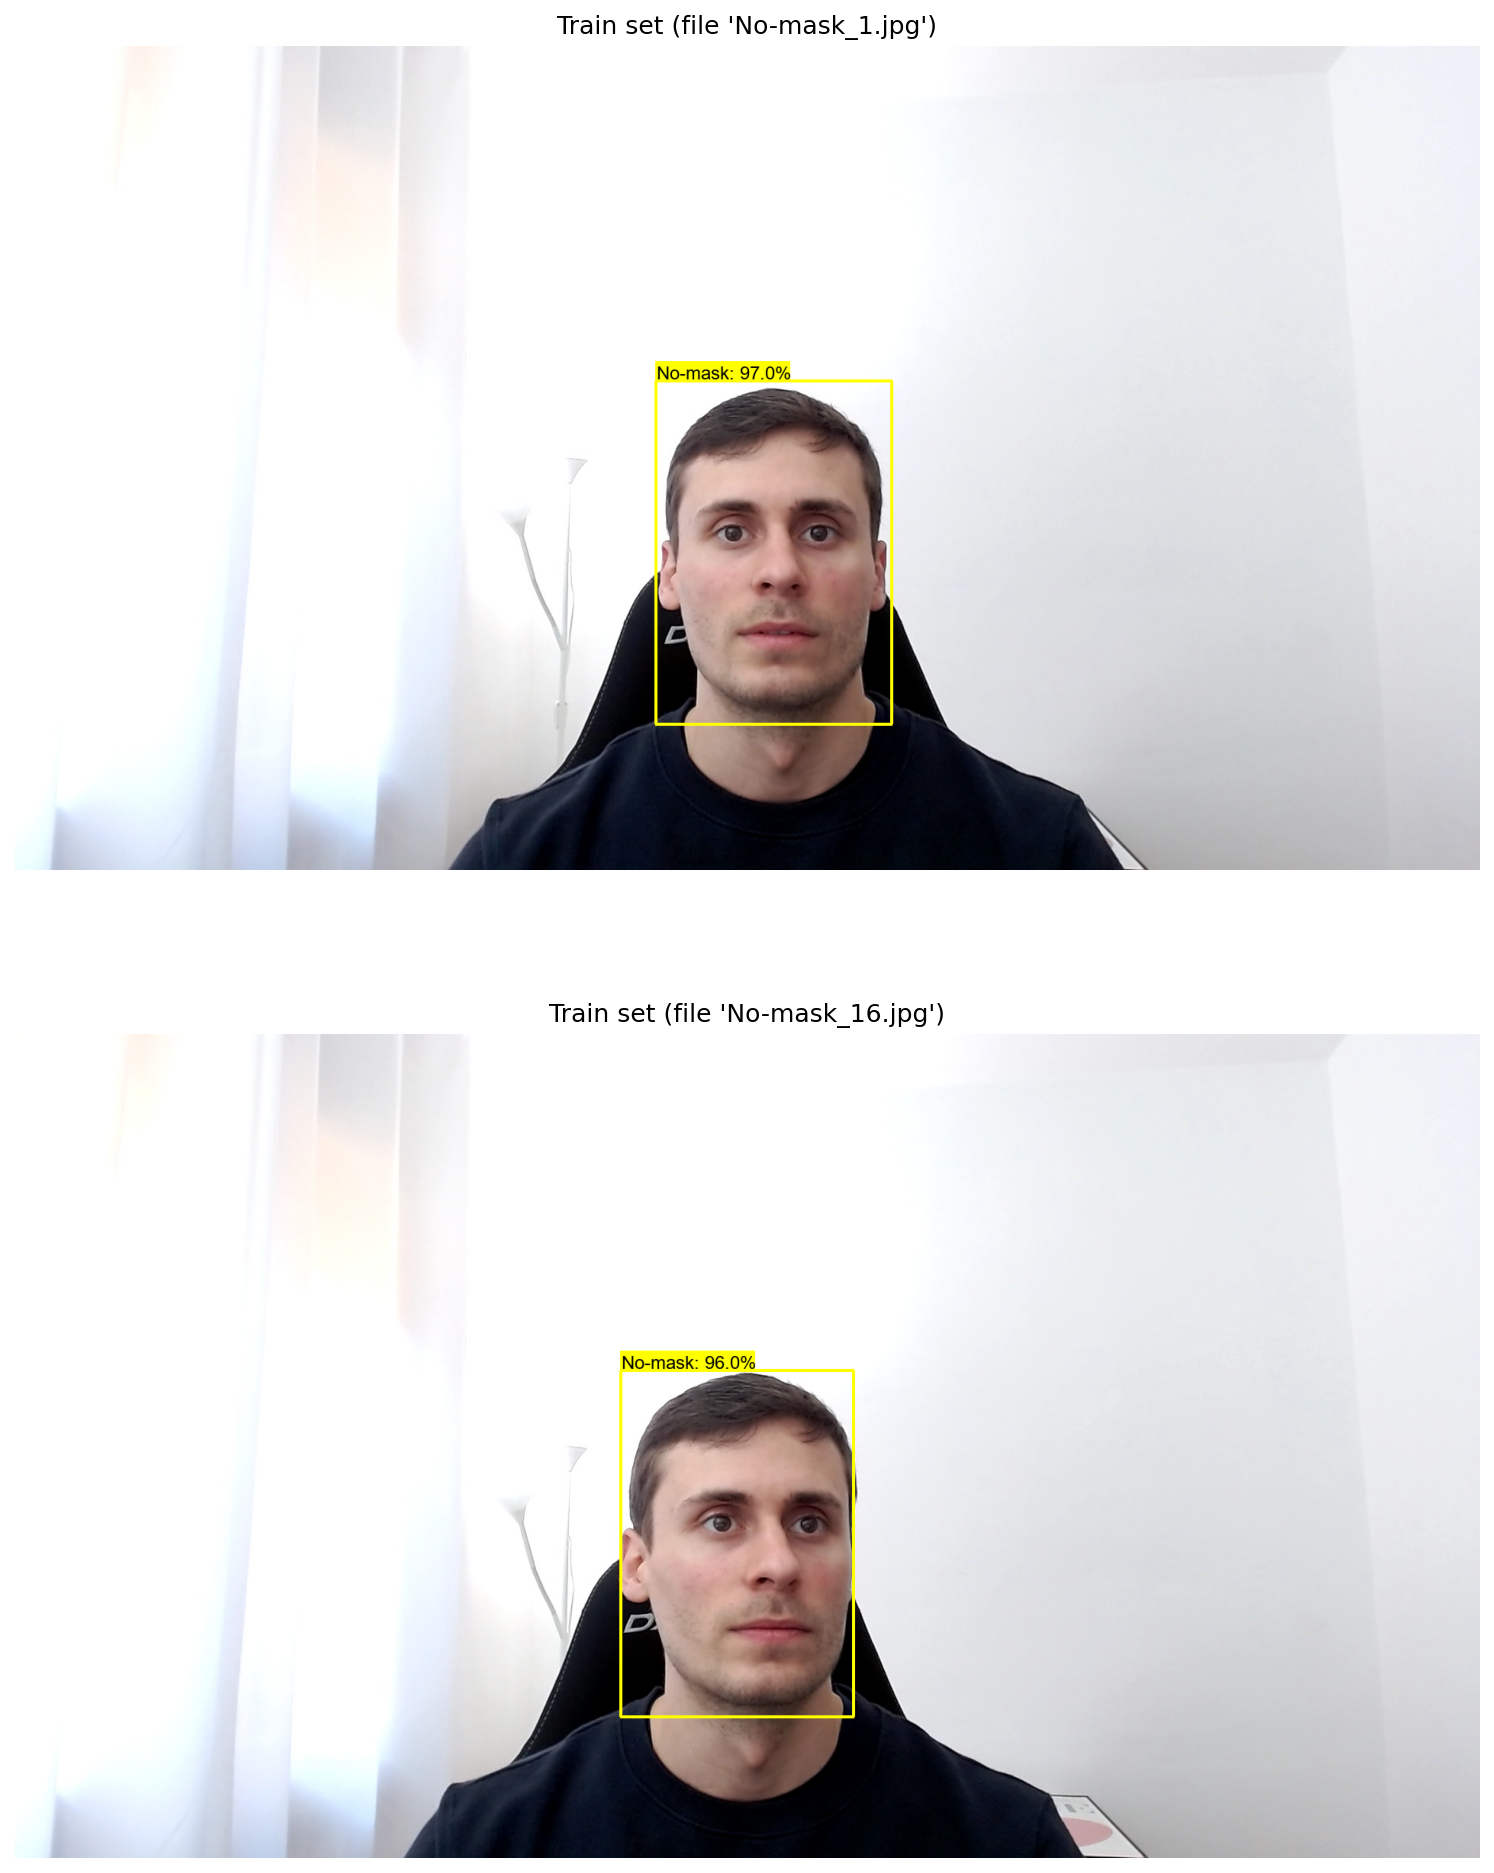

In [59]:
# Number of pictures in the grid
nrows = 2
ncols = 1

# Set up matplotlib fig
longitude_image = 16 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(nrows * longitude_image, nrows * longitude_image / 2)

# List all files per folder
train_files = os.listdir(TRAIN_DATA)
test_files = os.listdir(TEST_DATA)

# Remove non-relevant elements in folders
train_files = [pic for pic in train_files if pic.endswith('.jpg')]
test_files = [pic for pic in test_files if pic.endswith('.jpg')]

# Get paths to each file
train_pix = [os.path.join(TRAIN_DATA, fname) for fname in train_files]
test_pix = [os.path.join(TEST_DATA, fname) for fname in test_files]

# Get each image
num_set = nrows
for i, img_path in enumerate(random.sample(train_pix, num_set)):
    
    # Windows format
    if '\\' in img_path: 
        folder_name = img_path.split('\\')[2]
        picture_name = img_path.split('\\')[3]
    
    # Unix format
    else:
        folder_name = img_path.split('/')[2]
        picture_name = img_path.split('/')[3]
        
    # Final plot set up
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    predict_and_plot(img_path)
    plt.title("{} set (file '{}')".format(folder_name.capitalize(), picture_name))

# Save image
plt.savefig(os.path.join(PATH_IMAGES, 'prediction.png'), dpi=150)

### Test set

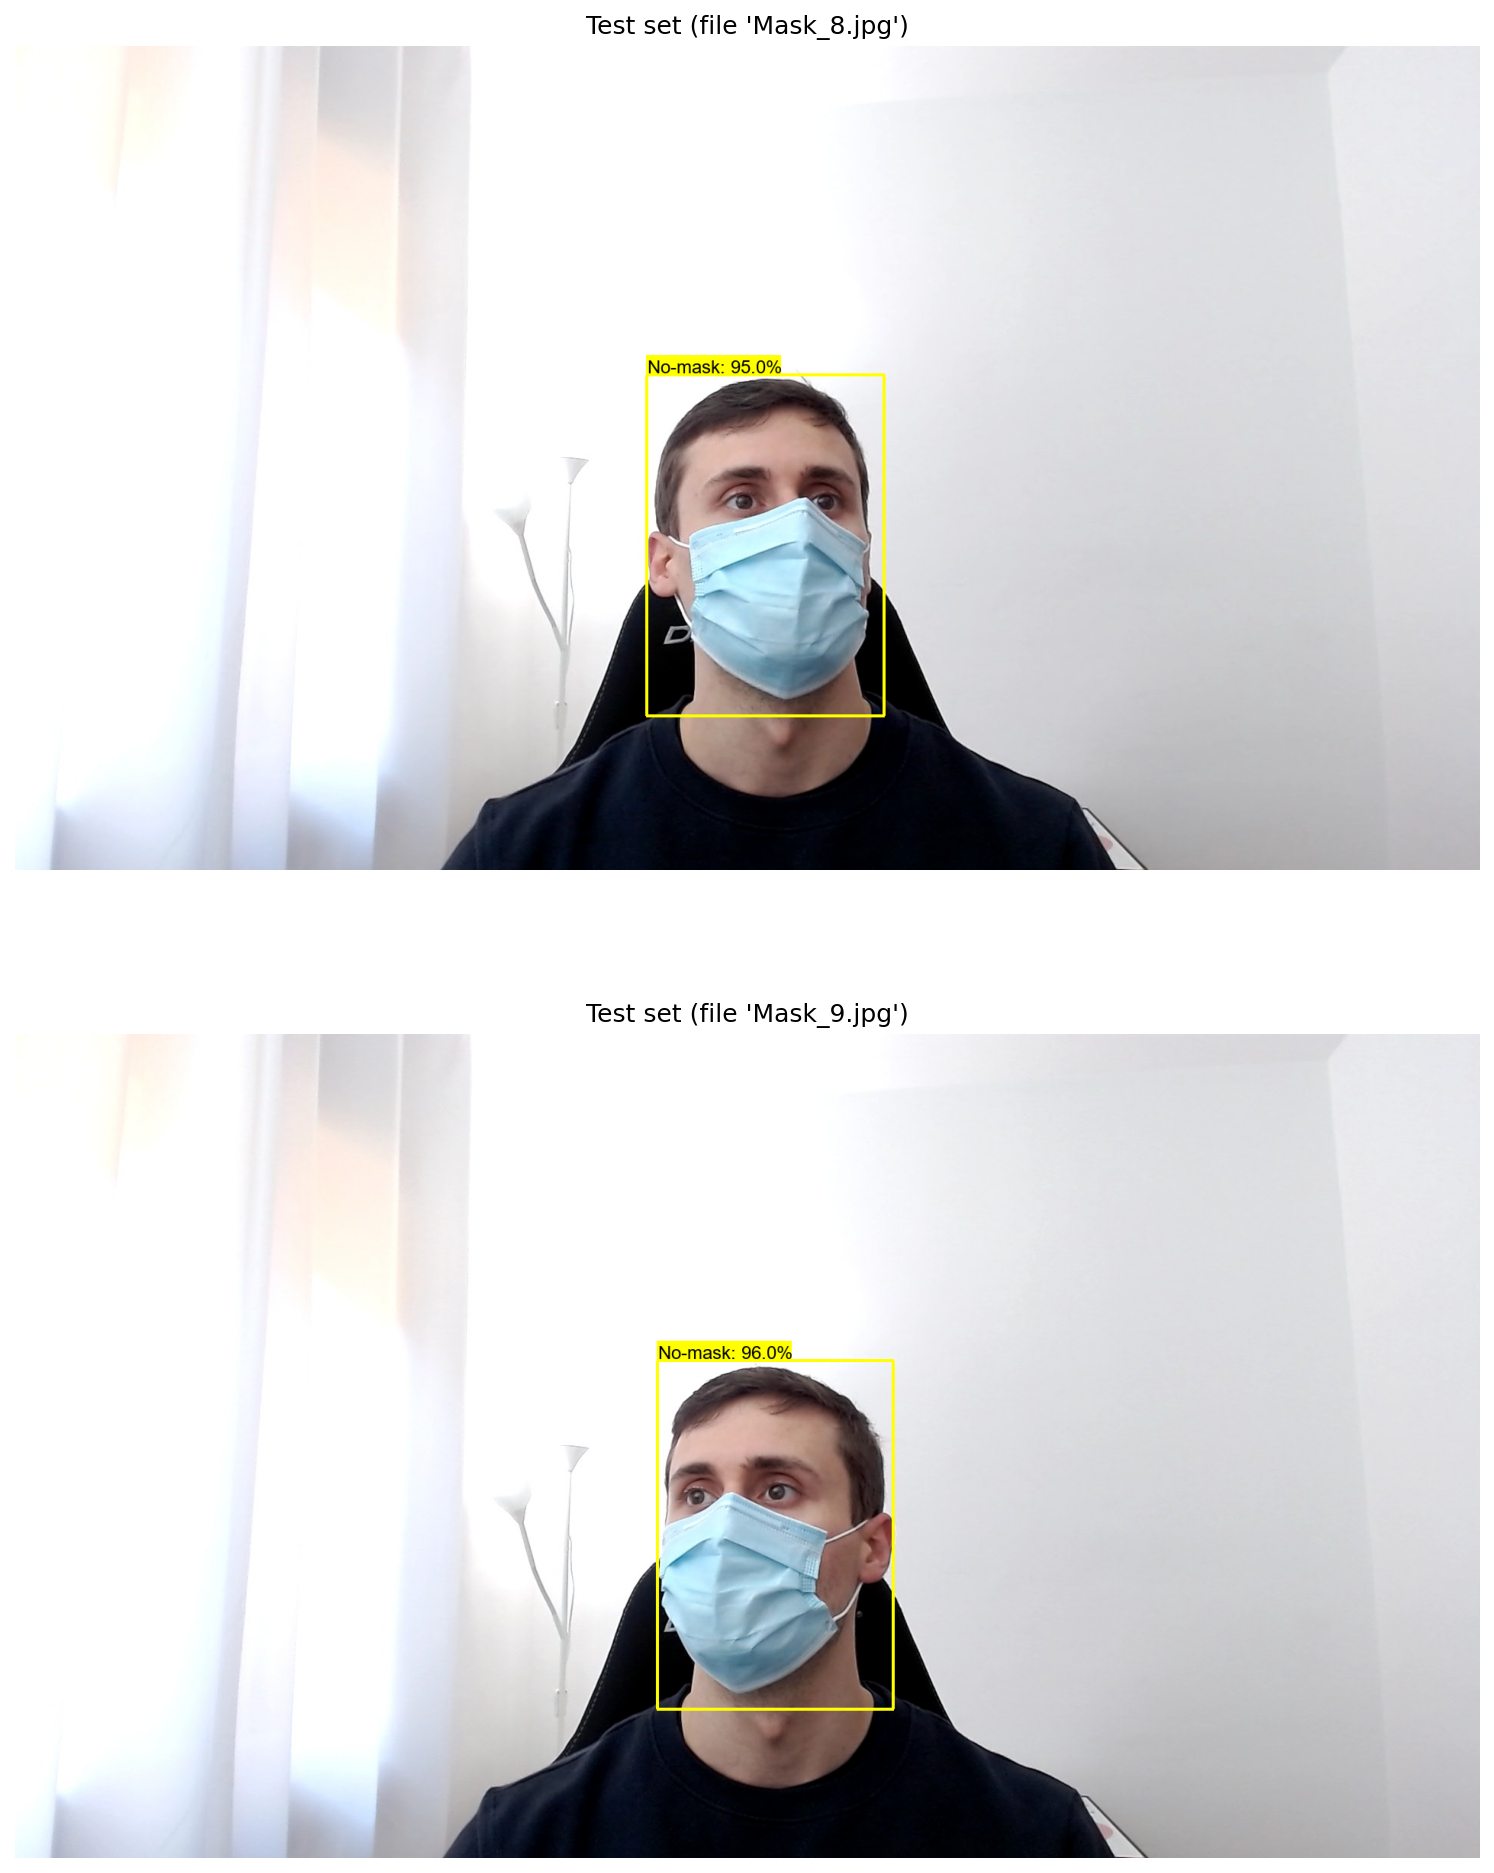

In [61]:
# Number of pictures in the grid
nrows = 2
ncols = 1

# Set up matplotlib fig
longitude_image = 16 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(nrows * longitude_image, nrows * longitude_image / 2)

# List all files per folder
train_files = os.listdir(TRAIN_DATA)
test_files = os.listdir(TEST_DATA)

# Remove non-relevant elements in folders
train_files = [pic for pic in train_files if pic.endswith('.jpg')]
test_files = [pic for pic in test_files if pic.endswith('.jpg')]

# Get paths to each file
train_pix = [os.path.join(TRAIN_DATA, fname) for fname in train_files]
test_pix = [os.path.join(TEST_DATA, fname) for fname in test_files]

# Get each image
num_set = nrows
for i, img_path in enumerate(random.sample(test_pix, num_set)):
    
    # Windows format
    if '\\' in img_path: 
        folder_name = img_path.split('\\')[2]
        picture_name = img_path.split('\\')[3]
    
    # Unix format
    else:
        folder_name = img_path.split('/')[2]
        picture_name = img_path.split('/')[3]
        
    # Final plot set up
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    predict_and_plot(img_path)
    plt.title("{} set (file '{}')".format(folder_name.capitalize(), picture_name))

# Save image
plt.savefig(os.path.join(PATH_IMAGES, 'prediction.png'), dpi=150)

## Try it with your webcam!

The set up instructions for this section, were obtained from this TensorFlow [tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html).

In [ ]:
@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [ ]:
# Select device: either the 'built-in' camera, or the 'external' one (useful for laptops).
device = 'external'

# Select camera
if device == 'built-in':
    cap = cv2.VideoCapture(0)
elif device == 'external':
    cap = cv2.VideoCapture(1)

In [ ]:
stop

In [ ]:
# Start video until 'q' is pressed
while True:
    
    # Read frame from camera
    ret, image_np = cap.read()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Convert image
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    # Visualise Real Team
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=1,
          min_score_thresh=.30,
          agnostic_mode=False)

    # Display output
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (1920, 1080)))
    
    # Set rules to break
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
        
# Close camera
cap.release()
cv2.destroyAllWindows()